# Analyzing Open MDC data

In this tutorial we will use `enterprise` to analyze open MDC dataset 1.

In [3]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler

from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'

## Get par and tim files

The first step in the process is getting the open MDC1 par and tim files in the tests directory.

In [7]:
parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

## Load pulsars into `Pulsar` objects

`enterprise` uses a specific [Pulsar]('../../_build/html/data.html#the-pulsar-class') object to store all of the relevant pulsar information (i.e. TOAs, residuals, error bars, flags, etc) from the timing package. Eventually `enterprise` will support both `PINT` and `tempo2`; however, for the moment it only supports `tempo2` through the [libstempo](https://github.com/vallis/libstempo) package. This object is then used to initalize `Signal`s that define the generative model for the pulsar residuals. This is in keeping with the overall `enterprise` philosophy that the pulsar data should be as loosley coupled as possible to the pulsar model.

In [ ]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)

## Setup and run a simple noise model on a single pulsar

Here we will demonstrate how to do a simple noise run on a single pulsar. In this analysis we will simply model the noise via a single EFAC parameter and a power-law red noise process.

### Set up model

Here we see the basic `enterprise` model building steps:

1. Define parameters and priors (This makes use of the [Parameter class factory]('../../_build/html/data.html#the-parameter-class'))
2. Set up the signals making use of the `Signal` class factories. 
3. Define the model by summing the individual `Signal` classes.
4. Define a PTA by initializing the signal model with a `Pulsar` object.

Notice that `powerlaw` is uses as a [Function]('../../_build/html/data.html#the-function-structure') here.

In [6]:
##### parameters and priors #####

# Uniform prior on EFAC
efac = parameter.Uniform(0.1, 5.0)

# red noise parameters 
# Uniform in log10 Amplitude and in spectral index
log10_A = parameter.Uniform(-18,-12)
gamma = parameter.Uniform(0,7)

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)

# timing model
tm = gp_signals.TimingModel()

# full model is sum of components
model = ef + rn + tm 

# initialize PTA
pta = signal_base.PTA([model(psrs[0])])

In [ ]:
#log10_A_dm = parameter.Uniform(-20, -11)
#gamma_dm = parameter.Uniform(0, 7)
#dm_spec = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
#dm_basis = utils.createfourierdesignmatrix_dm(nmodes=15, Tspan=Tspan)
#dmn = gp_signals.BasisGP(dm_spec, dm_basis, name='dm_gp')

We can see which parameters we are going to be searching over with:

In [8]:
print(pta.params)

["J0030+0451_efac":Uniform(0.1,5.0), "J0030+0451_gamma":Uniform(0,7), "J0030+0451_log10_A":Uniform(-18,-12)]


### Get initial parameters

We will start our MCMC chain at a random point in parameter space. We accomplish this by setting up a parameter dictionary using the `name` and `sample` methods for each `Parameter`.

In [13]:
xs = {par.name: par.sample() for par in pta.params}
print(xs)

{u'J0030+0451_efac': 4.7352650698633516, u'J0030+0451_gamma': 3.8216965873513029, u'J0030+0451_log10_A': -15.161366939011094}


Note that the rest of the analysis here is dependent on the sampling method and not on `enterprise` itself.

### Set up sampler

Here we are making use of the [PTMCMCSampler](https://github.com/jellis18/PTMCMCSampler) package for sampling. For this sampler, as in many others, it requires a function to compute the log-likelihood and log-prior given a vector of parameters. Here, these are supplied by `PTA` as `pta.get_lnlikelihood` and  `pta.get_lnprior`.

In [16]:
# dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# set up jump groups by red noise groups 
ndim = len(xs)
groups  = [range(0, ndim)]
groups.extend([[1,2]])

# intialize sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir='chains/mdc/open1/')

### Sample!

In [17]:
# sampler for N steps
N = 100000
x0 = np.hstack(p.sample() for p in pta.params)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 10.00 percent in 7.578883 s Acceptance rate = 0.27876Adding DE jump with weight 50
Finished 99.00 percent in 77.849424 s Acceptance rate = 0.404505
Run Complete


### Examine chain output

We see here that we have indeed recovered the injected values!

In [18]:
chain = np.loadtxt('chains/mdc/open1/chain_1.txt')
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])

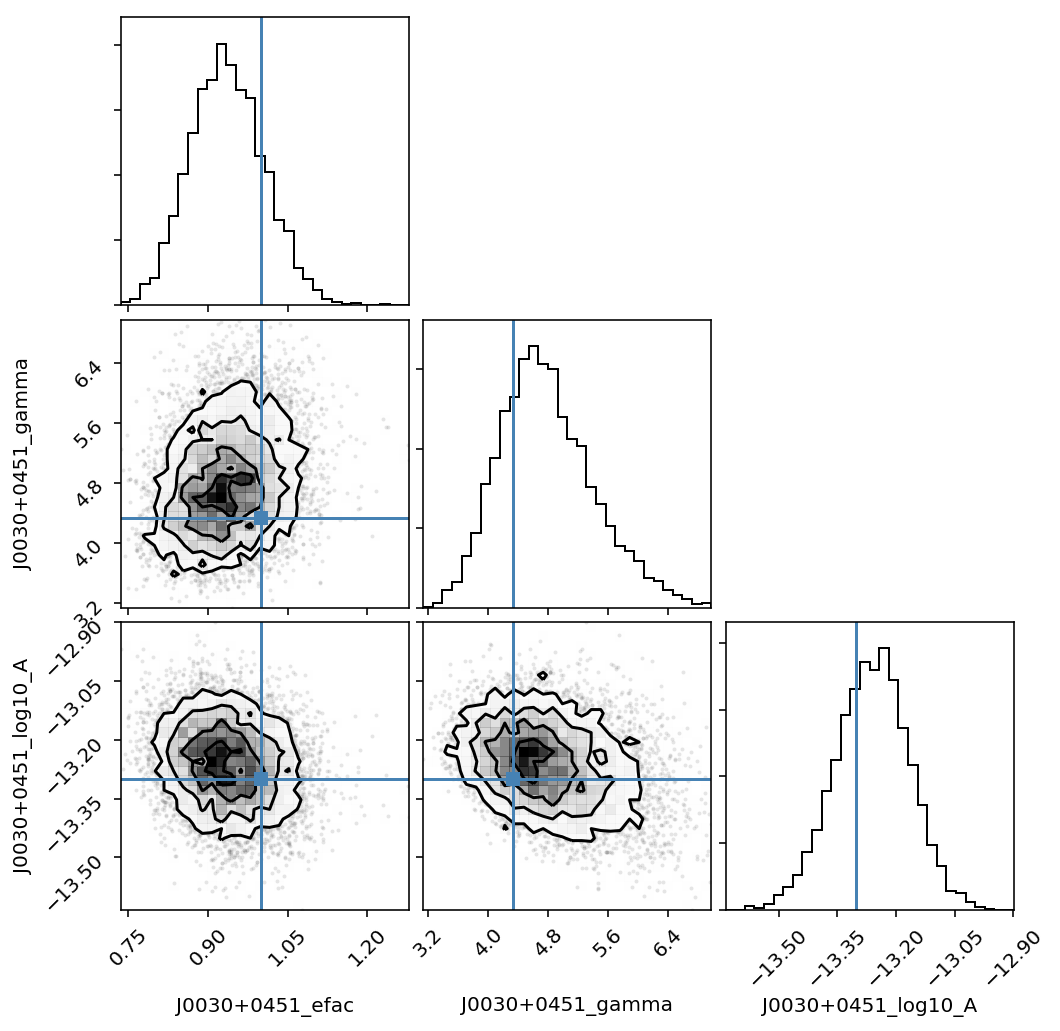

In [22]:
truths = [1.0, 4.33, np.log10(5e-14)]
corner.corner(chain[burn:,:-4], 30, truths=truths, labels=pars);